In [1]:
import pandas as pd
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DataConversionWarning)

In [38]:
#preprocessing
# def removeUnknown(df_in, col, match):
#     df = df_in.copy()

#     df = df.loc[df[col] != match]
#     return df

# df = pd.read_csv('terrorism_new.csv')
# cols = ['iyear', 'extended', 'latitude', 'longitude', 'attacktype1', 'success', 'suicide', 'targtype1', 'gname', 'nperps', 'nkill', 'nwound', 'property']
# df = df.loc[:, cols]

# #remove all unknown
# for col in cols:
#     df = removeUnknown(df, col, 'Unknown')
#     df = removeUnknown(df, col, -9)
#     df = removeUnknown(df, col, -99)
    
# df = df.dropna()
# le = preprocessing.LabelEncoder()
# gname_cat = le.fit_transform(dataset['gname'])
# dataset['gname'] = gname_cat
# df.to_csv('trimmed_dataset.csv', index = False)


In [5]:
def preprocess_data(dataset, incident_count):
    #remove Unknown terrorist groups
    dataset = dataset[dataset['gname'] != "Unknown"]
    #drop rows with NaN values
    dataset = dataset.dropna()
    
    #attack counts per group
    group_attack_count = {}
    for i in dataset['gname']:
        if i in group_attack_count:
            group_attack_count[i] = 1 + group_attack_count[i]
        else:
            group_attack_count[i] = 1
            
    #list to determine which rows to discard later on (if in this list, gname has <500 attacks)
    to_discard = []
    for i in group_attack_count:
        if group_attack_count[i] < incident_count:
            to_discard.append(i)
            
    #map that contains gnames and their attack counts (must have >= 500 attacks)
    #this map is not used in model building, but is useful to see spread of attacks across gnames we are interested in
    to_keep_map = {}
    for i in group_attack_count:
        if group_attack_count[i] >= incident_count:
            to_keep_map[i] = group_attack_count[i]
    
    #trim dataset to only include gnames we are interested in, we are not interested in gnames that are in to_discard
    dataset = dataset[~dataset['gname'].isin(to_discard)]
    
    #make a dictionary to map each gname to a number
    name_map = {}
    unique_gname = dataset['gname'].unique()
    for i in range(len(unique_gname)):
        name_map[unique_gname[i]] = i
    
    dataset = dataset.replace({"gname":name_map})
    
    return dataset

In [6]:
def plotPrecisionRecall(recall_micro, precision_micro, avgPrecise_micro):
    plt.figure()
    plt.step(recall_micro, precision_micro, where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(
        'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
        .format(avgPrecise_micro))

In [7]:
def plotPrecisionRecallBinary(forest_classifier, X_test, y_test, average_precision):
    disp = plot_precision_recall_curve(forest_classifier, X_test, y_test)
    disp.ax_.set_title('2-class Precision-Recall curve: '
                       'AP={0:0.2f}'.format(average_precision))

In [115]:
def gridSearch(dataset, output_label, verbose=2):
    X = dataset.drop(output_label, axis = 1)
    
    if output_label == 'gname':
        le = preprocessing.LabelEncoder()
        gname_cat = le.fit_transform(dataset[output_label])
        dataset[output_label] = gname_cat
        
    Y = dataset[output_label]
    
    param_grid = {
    'n_estimators' : [100, 250],
    'max_features': ['sqrt', None],
    'min_samples_leaf' : [1, 20, 100],
    }
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)
    
    rf = RandomForestClassifier()
    clf = GridSearchCV(rf, param_grid, verbose = verbose, cv = 2, scoring = 'f1_weighted', n_jobs = -1)
        
    clf.fit(X_train, y_train)

    print("Optimal Parameters: {}".format(clf.best_params_))
    
    forest_classifier = clf.best_estimator_
    
    # Instantiate model with 1000 decision trees
#     forest_classifier = RandomForestClassifier(n_estimators = 100)
    # Train the model on training data
    forest_classifier.fit(X_train, y_train)
    acc = forest_classifier.score(X_test, y_test)
    print("The accuracy is: {}".format(acc))
    
    y_score = forest_classifier.predict(X_test)
    
    f1 = f1_score(y_test, y_score, average = 'weighted')
    print("The F1 score is: {}".format(f1))
    
    if output_label == 'success':
        average_precision = average_precision_score(y_test, y_score)
        print('Average precision-recall score: {0:0.2f}'.format(
              average_precision))
        plotPrecisionRecallBinary(forest_classifier, X_test, y_test, average_precision)

#     return acc, f1

In [116]:
def wrapper(label, withClusters):
    rfe_dict = {
        "success" : ['iyear', 'latitude', 'longitude', 'attacktype1', 'nkill', 'nwound', 'targtype1', 'property', 'gname', 'nperps', 'suicide', 'extended', 'success'],
        "gname" : ["iyear", "latitude", "longitude", "targtype1", "nperps", "nkill", "gname"],
        "targtype1" : ["iyear", "latitude", "longitude", "nperps", "gname", "nkill", "nwound", "property", "attacktype1", "success", "suicide", "targtype1"]
    }
    
    df = preprocess_data(pd.read_csv('trimmed_dataset.csv'),0)
    cols = rfe_dict[label]
    df = df[cols]
    print("Predicting Label: {}, using Clusters: {}".format(label, withClusters))
    
    if withClusters:
        df_cluster = pd.read_csv('cluster.csv')
        df['cluster'] = df_cluster['cluster']
    
    print("shape: {}".format(df.shape))
    gridSearch(df, label, 0)
    

Predicting Label: success, using Clusters: False
shape: (15374, 13)
Optimal Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 250}
The accuracy is: 0.9401690873618036
The F1 score is: 0.9366687397522415
Average precision-recall score: 0.95


Predicting Label: success, using Clusters: True
shape: (15374, 14)
Optimal Parameters: {'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 250}
The accuracy is: 0.9386516366789508
The F1 score is: 0.9358635748453752
Average precision-recall score: 0.95


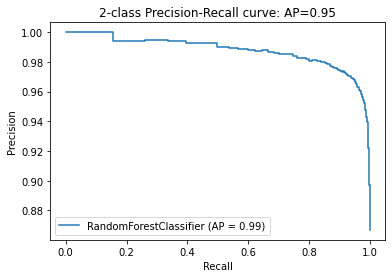

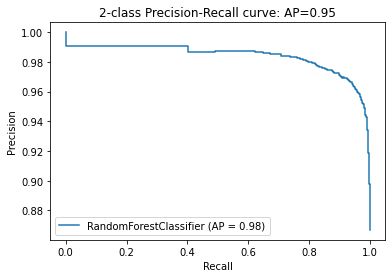

In [118]:
wrapper("success", False)
print('\n')
wrapper("success", True)

In [119]:
wrapper("gname", False)
print('\n')
wrapper("gname", True)

Predicting Label: gname, using Clusters: False
shape: (15374, 7)


/Users/xiaoqi.lim/Desktop/FYP/data-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Optimal Parameters: {'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 250}
The accuracy is: 0.6865380446564058
The F1 score is: 0.6639201323915402


Predicting Label: gname, using Clusters: True
shape: (15374, 8)


/Users/xiaoqi.lim/Desktop/FYP/data-env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(("The least populated class in y has only %d"


Optimal Parameters: {'max_features': None, 'min_samples_leaf': 1, 'n_estimators': 250}
The accuracy is: 0.6802514632560156
The F1 score is: 0.6563347458069281


In [120]:
wrapper("targtype1", False)
print('\n')
wrapper("targtype1", True)

Predicting Label: targtype1, using Clusters: False
shape: (15374, 12)
Optimal Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 250}
The accuracy is: 0.4313895512681552
The F1 score is: 0.4217366315476736


Predicting Label: targtype1, using Clusters: True
shape: (15374, 13)
Optimal Parameters: {'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 250}
The accuracy is: 0.42228484717103837
The F1 score is: 0.4124330399090054
